In [1]:
import numpy as np  # package for arrays
import matplotlib.pyplot as plt  # package for plotting
import time  # for timing
# display plots inside of notebook
%matplotlib inline

We have an $M$ by $N$ lattice of spins. Let $\sigma_i \in \{-1, 1\}$ be the spin of lattice site $i$. The energy of the system is:

$\sum_{(i,j)} ' J \sigma_i \sigma_j - \sum_j h \sigma _j$,
    
where the prime denotes a sum over nearest neighbors on the $M$ by $N$ lattice.

We implement periodic boundary conditions to mimic a system of infinite extent.

The following class, `IsingModel`, is a data structure to store attributes of an Ising Model and provide abstractions to manipulate the lattice for simulations.

For example, to construct an instance of an `IsingModel` class as a 20 by 10 lattice with $J=1.0$ and $h=0$:

    model = IsingModel(20, 10, 1.0, 0.0)
    model.print_attributes()

The lattice state is stored in an $M$ by $N$ numpy array, `lattice_state`; each entry is either -1 and 1. Each site of the lattice is initialized as -1 or 1 with equal probability in the initial construction of an instance. Retreive the lattice state by:

    model.lattice_state
    
Plot the lattice state by:

    model.plot_lattice()
    
We can conveniently manipulate the lattice for simulations. For example, to flip the spin in row 2 and column 3 and calculate the energy of this spin:

    model.flip_spin(2, 3)
    model.calculate_energy_of_spin(2, 3)
    

In [2]:
class IsingModel:
    """
    Store attributes of an Ising lattice model
    Provide abstractions to conveniently manipulate lattice for simulations
    """
    def __init__(self, M, N, J, h):
        """
        Initialization.
        
        parameters:
            lattice is M by N sites
            J: interaction between neighbors (units: kT)
            h: background field (units: kT)
        """
        # store parameters for convenience:
        #   energetic parameters
        self.J = J
        self.h = h
        
        #   size of lattice
        self.M = M
        self.N = N
        
        # store lattice state with M by N array of -1 or 1
        # initialize each site as -1 or 1 with equal probability
        lattice_state = np.random.randint(-1, high=1, size=(M, N))
        lattice_state[lattice_state == 0] = 1
        self.lattice_state = lattice_state
    
    def print_params(self):
        """
        Print lattice attributes
        """
        print("%d by %d lattice" % (self.M, self.N))
        print("J = %f" % self.J)
        print("h = %f" % self.h)
    
    def critical_kT(self):
        """
        Calculate critical temperature of this lattice model. Depends on J.
        """
        return 2.0 * self.J / (np.log(1.0 + np.sqrt(2.0)))
    
    def flip_spin(self, i, j):
        """
        Flip spin (i, j)
        i.e. -1 ---> 1
              1 ---> -1
        """
        self.lattice_state[i, j] = - self.lattice_state[i, j]
    
    def calculate_energy_of_spin(self, i, j):
        """
        Calculate energy of spin (i, j)
        
        Periodic boundary conditions implemented
        """
        spin_here = self.lattice_state[i, j]  # value of spin here
        
        # value of spin above, below, left, and right of spin (i, j)
        # for each, if on boundary, we wrap around to the other side
        # of the lattice for periodic boundary conditions
        if j == 0:
            spin_above = self.lattice_state[i, self.N - 1]
        else:
            spin_above = self.lattice_state[i, j - 1]
        
        if j == self.N - 1:
            spin_below = self.lattice_state[i, 0]
        else:
            spin_below = self.lattice_state[i, j + 1]
            
        if i == self.M - 1:
            spin_right = self.lattice_state[0, j]
        else:
            spin_right = self.lattice_state[i + 1, j]
        
        if i == 0:
            spin_left = self.lattice_state[self.M - 1, j]
        else:
            spin_left = self.lattice_state[i - 1, j]
        
        return - self.h * spin_here +  self.J * spin_here *\
            (spin_above + spin_below + spin_left + spin_right)
        
    def plot_lattice(self):
        """
        Plot lattice configuration
        """
        plt.figure()
        
        imgplot = plt.imshow(self.lattice_state)
        imgplot.set_interpolation('none')
        
        plt.xticks(range(self.N))
        plt.yticks(range(self.M))
        
        plt.show()
    
    def calculate_lattice_energy_per_spin(self):
        """
        Calculate energy of lattice normalized by the number of spins
        """
        E = 0.0
        for i in range(self.M):
            for j in range(self.N):
                E = E + self.calculate_energy_of_spin(i, j)
        return E / 2.0 / (self.M * self.N) # factor of two for overcounting
    
    def calculate_net_magnetization_per_spin(self):
        """
        Calculate net magentization normalized by the number of spins
        """
        return 1.0 * np.sum(self.lattice_state) / (self.M * self.N)
        

## Example use

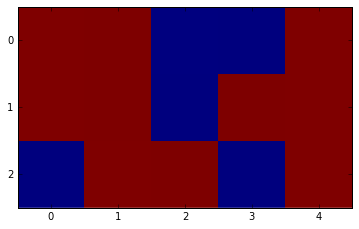

In [3]:
model = IsingModel(3, 5, 1.0, 0.0)
model.plot_lattice()

In [4]:
model.calculate_energy_of_spin(2, 0)

-4.0

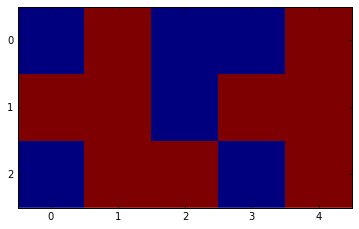

In [5]:
model.flip_spin(0, 0)
model.plot_lattice()

# Autocorrelation functions to determine how many sweeps needed before samples become statistically independent

In [6]:
def autocorrelation_k_steps(data, k):
    """
    Calculate autocorrelation of data after k steps
    https://en.wikipedia.org/wiki/Autocorrelation#Estimation
    """
    mu = np.mean(data)  # mean
    n = np.size(data)  # number of data points
    variance = np.var(data)  # variance
    
    corr = 0.0  # autocorrelation
    for t in range(n - k):
        corr += (data[t] - mu) * (data[t + k] - mu)
    return corr / (variance * (n - k))

def plot_autocorrelation(data, kmax):
    """
    Plot autocorrelation function of data up to kmax steps
    """
    corr = np.zeros((kmax, ))
    for k in range(kmax):
        corr[k] = autocorrelation_k_steps(data, k)
        
    fig = plt.figure()
    plt.xlabel("Monte Carlo cycle")
    plt.ylabel("Autocorrelation")
    plt.plot(np.arange(kmax), corr, marker='s')
    plt.show()

# Function to sweep the lattice in a Monte Carlo simulation

Our function `sweep_lattice` will perform $NM$ Monte Carlo spin flip trials. We call it `sweep_lattice` because, on average, each spin will be selected for a Monte Carlo trial once during a 'sweep'.

In [7]:
def sweep_lattice(isingmodel, kT):
    """
    Perform N*M Monte Carlo spin flip attempts
    
    parameters:
        isingModel: Ising lattice model object instance
        kT: Boltzmann constant times temperature, $kT$
    """
    num_flips = isingmodel.M * isingmodel.N
    
    for flip in range(num_flips):
        # choose a spin to flip at random
        i = np.random.randint(0, high=isingmodel.M)
        j = np.random.randint(0, high=isingmodel.N)
        
        # calculate old energy
        E_old = isingmodel.calculate_energy_of_spin(i, j)
        
        # flip the spin
        isingmodel.flip_spin(i, j)
        
        # calculate new energy
        E_new = isingmodel.calculate_energy_of_spin(i, j)
        
        # Monte Carlo: accept this proposal with probability e^{-\beta \Delta E}
        if np.random.uniform(0, 1) > np.exp(-(E_new - E_old) / kT):
            # reject move, flip spin back to original state
            isingmodel.flip_spin(i, j)
        # else: accept, do nothing

# Function for Monte Carlo simulations of Ising Model in Canonical Ensemble

In [8]:
def simulate(isingmodel, kT, num_sweeps, num_burn_sweeps, sample_frequency):
    """
    Monte Carlo simulations of Ising model in Canonical ensemble
    
    parameters:
        isingModel: Ising lattice model object instance
        kT: Boltzmann constant times temperature, $kT$
        num_sweeps: total number of Monte Carlo sweeps to perform in the simulation
        num_burn_sweeps: number of sweeps for equilibration (no samples taken during this period)
        sample_frequency: frequency at which to take samples
    """  
    t0 = time.time()
    
    # store energy and net magnetization samples here
    energy_samples = np.zeros(((num_sweeps - num_burn_sweeps) / sample_frequency, ))
    magnetization_samples = np.zeros(((num_sweeps - num_burn_sweeps) / sample_frequency, ))
    
    # keep track of number of samples
    n_samples = 0

    for sweep in range(num_sweeps):
        # sweep lattice
        sweep_lattice(model, kT)

        # take samples
        if sweep >= num_burn_sweeps:
            if ((sweep - num_burn_sweeps) % sample_frequency) == 0:
                energy_samples[n_samples] = model.calculate_lattice_energy_per_spin()
                
                magnetization_samples[n_samples] = model.calculate_net_magnetization_per_spin()
                
                n_samples += 1
    
    print "\tSimulation finished. Took %s sec." % (time.time() - t0)
    
    return energy_samples, magnetization_samples

In [9]:
model = IsingModel(30, 30, 1.0, 0.0)
critical_kT = model.critical_kT()

	Simulation finished. Took 51.3740170002 sec.


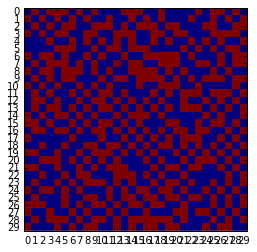

In [10]:
energy_samples, magnetization_samples = simulate(model, critical_kT * 1.3, 10000, 1000, 1)
model.plot_lattice()

In [11]:
energy_samples

array([-0.94222222, -0.85333333, -0.82666667, ..., -0.78222222,
       -0.78666667, -0.84      ])

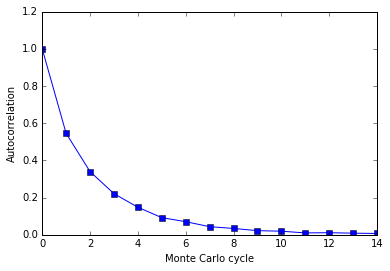

In [12]:
plot_autocorrelation(energy_samples, 15)